# Notebook Quentin Heitz, Arthur Brosseau, Loan Perrard

## Persona : Investisseur dans l’immobilier étudiant
Notre investisseur a pour objectif de trouver les logements étudiants les plus rentables afin de faire fructifier son argent.
Il s’intéresse à différents points, comme :

1) La rentabilité foncière
2) La proportion des etudiants dans la ville
3) Evolution nombre d'etudiants par année
4) La tension locative avec le nombre de logements demandés/vacants
5) La quantité de transports
6) Comparaison sur la qualité du réseau électrique
7) Insecurité par communes

Il cherche un outil simple qui lui permette de comparer plusieurs biens rapidement, d’évaluer leur rentabilité, et de réduire les risques avant d’investir.

Un tel outil lui permettrait donc de gagner du temps, de sécuriser ses investissements et d’avoir une vision globale de la rentabilité avant même de visiter un bien. Il pourrait ainsi investir plus sereinement, tout en continuant à développer son patrimoine.

### Importation des bibliotheques

In [363]:
import pandas as pd
import geopandas as gpd
import folium
import branca.colormap as cm
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output, HTML

plt.style.use('seaborn-v0_8-pastel')

# Chargement des jeux de données (DVF 2023/2024 & Loyers)

Cette cellule charge les bases DVF 2023/2024 et le fichier des loyers prédit au m².

In [364]:
df_2024 = pd.read_csv("communesdvf2024.csv")
df_2023 = pd.read_csv("dvf2023.csv", sep=',', quotechar='"', index_col=0)
df_loyers_commune = pd.read_csv("pred-app-mef-dhup.csv", sep=';', encoding='latin-1')


# Nettoyage & uniformisation DVF (harmonisation des colonnes 2023/2024)

On aligne les noms de colonnes de 2023 sur 2024, on nettoie les codes INSEE et on concatène les deux millésimes pour faciliter les jointures ultérieures.

In [365]:

df_2023 = df_2023.rename(columns={
    "Annee": "annee",
    "Nb_mutations": "nb_mutations",
    "propmaison": "PropMaison",
    "propappart": "PropAppart"
})

df_2023['INSEE_COM'] = df_2023['INSEE_COM'].astype(str).str.replace('"', '').str.strip()
df_2024['INSEE_COM'] = df_2024['INSEE_COM'].astype(str).str.replace('"', '').str.strip()

colonnes_dvf = ['INSEE_COM', 'annee', 'nb_mutations', 'NbApparts', 'PropAppart', 'PrixMoyen', 'Prixm2Moyen', 'SurfaceMoy']
df_2023 = df_2023[colonnes_dvf]
df_2024 = df_2024[colonnes_dvf]
df_dvf = pd.concat([df_2023, df_2024], ignore_index=True)
df_dvf['INSEE_DEP'] = df_dvf['INSEE_COM'].str[:2]

# Préparation des loyers communaux
Conversion du loyer prédit au m² (virgule → point) et sélection des colonnes clés.

In [366]:

df_loyers_commune = df_loyers_commune.rename(columns={'INSEE_C': 'INSEE_COM'})

df_loyers_commune['loypredm2'] = (df_loyers_commune['loypredm2'].astype(str).str.replace(',', '.', regex=False).astype(float))

df_loyers_commune = df_loyers_commune[['INSEE_COM', 'LIBGEO', 'loypredm2']]

# Focus DVF 2024 & jointure avec les loyers
On isole 2024 pour le calcul de la rentabilité et on ne garde que les communes présentes dans les deux sources (inner join sur INSEE_COM).


In [367]:
df_dvf_2024 = df_dvf[df_dvf['annee'] == 2024].copy()

df_final = pd.merge(df_dvf_2024, df_loyers_commune, on='INSEE_COM', how='inner')


df_dvf_2023 = df_dvf[df_dvf['annee'] == 2023].copy()
df_dvf_2023 = df_dvf_2023.rename(columns={'Prixm2Moyen': 'Prixm2Moyen_2023'})
df_dvf_2023 = df_dvf_2023[['INSEE_COM', 'Prixm2Moyen_2023']]

df_final = pd.merge(df_final, df_dvf_2023, on='INSEE_COM', how='left')

df_final['Evolution_Prix_M2'] = (
    (df_final['Prixm2Moyen'] / df_final['Prixm2Moyen_2023'] - 1) * 100
)


df_final['Rentabilite_Brute'] = ((df_final['loypredm2'] * 12) / (df_final['Prixm2Moyen'])) * 100

df_travail = df_final.rename(columns={'Prixm2Moyen': 'Prixm2Moyen_2024'}).round(2)


# Analyse du marché financier

Ce widget a pour but de visualiser le marché financier utilisé dans son ensemble. 
On y retrouve toutes les communes de notre dataset placées sur le graphique en fonction du prix au m² et de leur surface moyenne.

La taille des points représente le nombre de transaction sur l'année de la commune. 
Plus le point est gros, plus la ville est dynamique au niveau du marché financier.

In [368]:


import plotly.express as px
from ipywidgets import interact, Dropdown, FloatSlider, VBox, Layout, HTML
from IPython.display import display, clear_output
from scipy.stats import linregress

#ouverture des fichiers necessaires et on les harmonise
df_2024 = pd.read_csv("communesdvf2024.csv")
df_2023 = pd.read_csv("dvf2023.csv", sep=',', quotechar='"', index_col=0)


df_2023 = df_2023.rename(columns={
    "Annee": "annee", "Nb_mutations": "nb_mutations",
    "propmaison": "PropMaison", "propappart": "PropAppart"
})


df_2023['INSEE_COM'] = df_2023['INSEE_COM'].astype(str).str.replace('"', '').str.strip()
df_2024['INSEE_COM'] = df_2024['INSEE_COM'].astype(str).str.replace('"', '').str.strip()


colonnes_dvf = ['INSEE_COM', 'annee', 'nb_mutations', 'NbApparts', 'PropAppart', 'PrixMoyen', 'Prixm2Moyen', 'SurfaceMoy']
df_2023 = df_2023[colonnes_dvf]
df_2024 = df_2024[colonnes_dvf]


df_dvf = pd.concat([df_2023, df_2024], ignore_index=True)
df_dvf_2024 = df_dvf[df_dvf['annee'] == 2024].copy()

#extraction du fichier avec les loyers et on le merge au dataframe final
df_loyers_commune = pd.read_csv("pred-app-mef-dhup.csv", sep=';', encoding='latin-1')
df_loyers_commune = df_loyers_commune.rename(columns={'INSEE_C': 'INSEE_COM'})
df_loyers_commune = df_loyers_commune[['INSEE_COM', 'LIBGEO']].drop_duplicates()
df_travail = pd.merge(df_dvf_2024, df_loyers_commune, on='INSEE_COM', how='inner')


# On supprime la grande majorité des communes qui n'ont pas de dynamisme au niveau de l'achat / revente des appartements. Si la commmune n'a pas minimum 50 transactions dans l'année on la supprime
df_travail = df_travail[df_travail['nb_mutations'] >= 50].copy()

df_travail.dropna(subset=['Prixm2Moyen', 'SurfaceMoy'], inplace=True)
df_travail = df_travail[(df_travail['SurfaceMoy'] >= 20) & (df_travail['SurfaceMoy'] <= 300)].copy()

# Renommage des colonnes pour l'affichage 
df_travail = df_travail.rename(columns={
    'Prixm2Moyen': 'Prix au m² (€)',
    'SurfaceMoy': 'Surface Moyenne (m²)',
    'nb_mutations': 'Dynamisme (Nb Transactions)',
    'PropAppart': 'Proportion Appartements (%)',
    'LIBGEO': 'Commune'
})



def plot_contexte_marche(dynamisme_min, dep_filter):
    
    df_filtered = df_travail.copy()
    
     # Filtrer par Département (si "Toutes" n'est pas sélectionné)
    df_filtered = df_filtered[df_filtered['Dynamisme (Nb Transactions)'] >= dynamisme_min]
    if dep_filter != "Toutes (France)":
        df_filtered['INSEE_DEP'] = df_filtered['INSEE_COM'].str[:2]
        df_filtered = df_filtered[df_filtered['INSEE_DEP'] == dep_filter]
    
    clear_output(wait=True) # Rafraîchit l'affichage avant de tracer le nouveau graphique.
    
    if df_filtered.empty:
        display(HTML(f"<b> Aucune commune ne correspond au filtre.</b>"))
        return
        
   # Calcul de la ligne de tendance pour affichage textuel
    try:
        slope, intercept, r_value, p_value, std_err = linregress(
            df_filtered['Surface Moyenne (m²)'], 
            df_filtered['Prix au m² (€)']
        )
    except ValueError:
        r_value = 0 
        
    
    
    
    fig = px.scatter(
        df_filtered,
        x='Surface Moyenne (m²)',
        y='Prix au m² (€)',
        size='Dynamisme (Nb Transactions)', 
        color='Proportion Appartements (%)', 
        color_continuous_scale=px.colors.sequential.Plasma,
        title="Contexte : Relation Prix Moyen au m² vs. Surface Moyenne (DVF 2024)",
        
        #pour que l'on est les infos en passant la souris dessus
        hover_data={
            'Commune': True, 
            'Prix au m² (€)': ':.0f',
            'Surface Moyenne (m²)': ':.1f',
            'Dynamisme (Nb Transactions)': True,
            'Proportion Appartements (%)': ':.1f'
        }
    )

    # afficher la ligne de tendance rouge pour comprendre comment evolue la relation entre les deux
    if r_value != 0:
        fig.add_scatter(
            x=df_filtered['Surface Moyenne (m²)'], 
            y=intercept + slope * df_filtered['Surface Moyenne (m²)'], 
            mode='lines',
            line=dict(color='red', dash='dash'),
            name=''
        )
        
    fig.update_layout(
        coloraxis_colorbar=dict(title="Proportion Appart. (%)", x=1.02, y=1.0, len=0.7),
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0.01, title=None)
    )
    
    fig.show() 


# Création de l'interactivité
style = {'description_width': 'initial'}

# On récupère les départements
departements = ['Toutes (France)']
if 'INSEE_COM' in df_travail.columns:
    df_travail['INSEE_DEP'] = df_travail['INSEE_COM'].str[:2]
    departements += sorted(df_travail['INSEE_DEP'].unique().tolist())


# La barre qui gère le nombre de transactions
slider_dynamisme = FloatSlider(
    min=50.0, 
    max=df_travail['Dynamisme (Nb Transactions)'].max(),
    step=50.0, 
    value=100.0, 
    description='Dynamisme Min. (Nb Transactions) :', 
    style=style, 
    layout=Layout(width='90%')
)

# filtre par departement
dropdown_dep = Dropdown(
    options=departements,
    value='Toutes (France)',
    description='Filtrer par Département :',
    style=style,
    layout=Layout(width='300px')
)

controles = VBox([slider_dynamisme, dropdown_dep])

# affichage
interact(
    plot_contexte_marche, 
    dynamisme_min=slider_dynamisme, 
    dep_filter=dropdown_dep
);

interactive(children=(FloatSlider(value=100.0, description='Dynamisme Min. (Nb Transactions) :', layout=Layout…

# TOP10 des marchés immobiliers
Ce classement identifie les villes avec le plus fort volume de transactions et une forte proportion d'appartements ce que recherhce notre investisseuse
Ces marchés sont les plus en mouvement donc les plus adaptées pour notre persona et une population étudiante

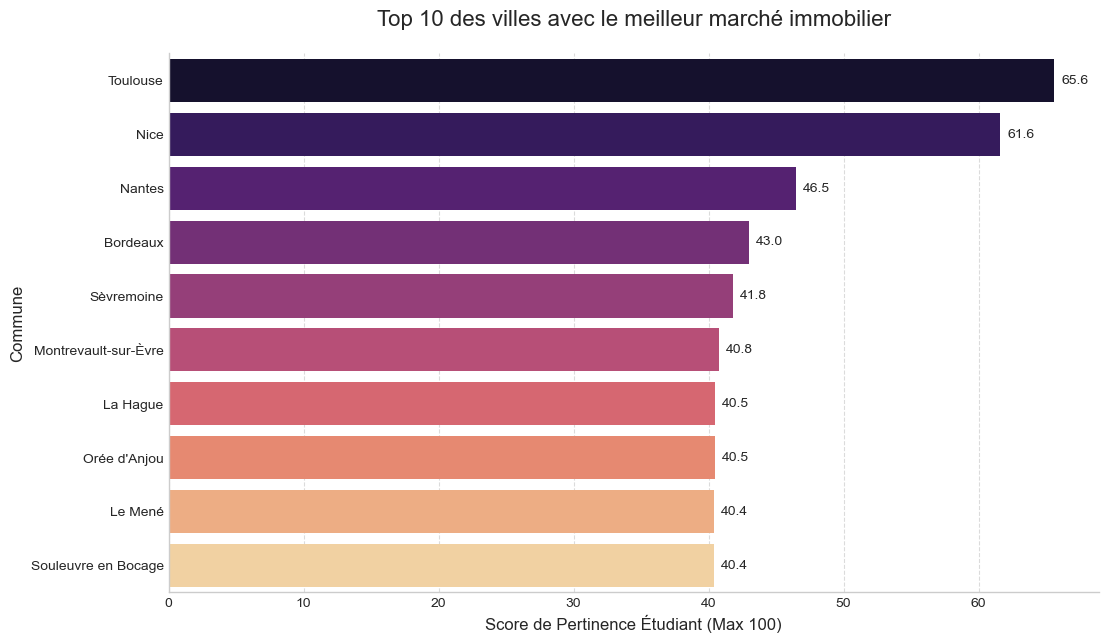

In [369]:


from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, HTML

df_etudiant_score = df_travail.copy()

#on normalise les valeurs pour qu'elles soient entre 0 et 100
scaler = MinMaxScaler()
df_etudiant_score['Score_Dynamisme'] = scaler.fit_transform(df_etudiant_score[['Dynamisme (Nb Transactions)']]) * 100
df_etudiant_score['Score_PropAppart'] = scaler.fit_transform(df_etudiant_score[['Proportion Appartements (%)']]) * 100


# On créer une pondération pour déterminer un score et classer les villes
df_etudiant_score['Score_Etudiant'] = (
    df_etudiant_score['Score_Dynamisme'] * 0.6
) + (
    df_etudiant_score['Score_PropAppart'] * 0.4
)

df_top10_etudiant = df_etudiant_score.sort_values(by='Score_Etudiant', ascending=False).head(10).copy()
df_top10_etudiant['Score_arrondi'] = df_top10_etudiant['Score_Etudiant'].round(1)


plt.figure(figsize=(12, 7))
ax = sns.barplot(
    x='Score_arrondi', 
    y='Commune', 
    data=df_top10_etudiant, 
    palette='magma' 
)

plt.title(
    "Top 10 des villes avec le meilleur marché immobilier", 
    fontsize=16,
    pad=20
)
plt.xlabel("Score de Pertinence Étudiant (Max 100)", fontsize=12)
plt.ylabel("Commune", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Ajout des étiquettes (labels) de valeur sur les barres
for p in ax.patches:
    ax.annotate(
        f"{p.get_width():.1f}", 
        (p.get_width(), p.get_y() + p.get_height() / 2), 
        xytext=(5, 0), 
        textcoords='offset points', 
        ha='left', 
        va='center', 
        fontsize=10
    )

sns.despine() 
plt.show()


In [370]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
import warnings
from ipywidgets import interact, Dropdown, Layout
from IPython.display import display

# Analyse interactive de la proportion d’étudiants par commune

Dans cette cellule, nous importons les données contenues dans le fichier `communes-france-2024.csv` à l'aide de la fonction 'read.csv()'

Le jeu de données est ensuite stocké dans la variable `communes_france` pour être exploité dnas la suite de l'analyse

In [371]:
communes_france = pd.read_csv(
    "communes-france-2024.csv",
)

age_par_ville_trié = pd.read_csv(
    "Age_par_ville_trié.csv",
)

Dans cette section, nous effectuons plusieurs étapes de préparation et d’intégration des données issues des fichiers sur les communes et la répartition par âge.

**1. Nettoyage du fichier des communes**

Les colonnes non pertinentes pour l’analyse sont supprimées à l’aide de drop().
L’objectif est d’alléger le DataFrame pour ne conserver que les variables nécessaires à la fusion.

**2. Harmonisation des noms de colonnes***

Les colonnes contenant les codes des ``EPCI`` (Établissements Publics de Coopération Intercommunale) sont renommées pour porter le même nom (EPCI) dans les deux jeux de données.
Cette homogénéisation est indispensable pour réaliser une jointure correcte entre les deux sources.

**3. Fusion des jeux de données**

Une jointure (``merge``) est réalisée sur la colonne ``EPCI`` entre :

communes_france_trié → informations administratives des communes,

age_par_ville_trié → répartition démographique par tranche d’âge.

**4. Regroupement des communes identiques**

Certaines communes peuvent apparaître plusieurs fois dans le dataset.
Elles sont donc regroupées par leur nom standard (nom_standard) à l’aide de la méthode ``groupby()``

**5. Filtrage des communes pertinentes**

On conserve uniquement les communes ayant une population significative de jeunes adultes ``(F18-24 > 1000)``.
Ce seuil permet de concentrer l’analyse sur les territoires à forte densité étudiante ou jeune.

**6. Export du jeu de données final**

Enfin, avec un dataFrame nettoyé et fusionné (``merge_communes_ages``) est exporté au format CSV (`merge_communes_ages.csv`)

In [372]:
communes_france_trié = communes_france.drop(columns=["Unnamed: 0", "code_insee","nom_a","nom_de","nom_sans_accent",
                                                     "nom_standard_majuscule","typecom","typecom_texte","url_villedereve",
                                                     "url_wikipedia", "gentile", "longitude_centre", "latitude_centre",
                                                     "latitude_mairie", "altitude_maximale", "altitude_minimale", "altitude_moyenne",
                                                     "superficie_hectare","academie_code","longitude_mairie", "code_insee_centre_zone_emploi",
                                                     "codes_postaux", "epci_nom", "canton_nom", "canton_nom", "canton_code",
                                                     "nom_sans_pronom", "academie_nom", "zone_emploi", "grille_densite","code_postal"])

communes_france_trié.rename(columns={"epci_code": "EPCI"}, inplace=True)
age_par_ville_trié.rename(columns={"EPCI": "EPCI"}, inplace=True)

#jointure 
age_par_ville_groupé_par_epci = age_par_ville_trié.groupby("EPCI", as_index=False).sum(numeric_only=True)

# --- Jointure ---
# Utilisation du DataFrame d'âge regroupé
merge_communes_age = pd.merge(
    communes_france_trié,
    age_par_ville_groupé_par_epci, # Utilisez le DataFrame pré-regroupé
    on = "EPCI",
    how = "left"
)

# --- Regroupement Final : Additionner les étudiants par Nom de Ville (c'est ce que vous aviez) ---
# Ceci additionne les étudiants pour toutes les lignes qui partagent le même 'nom_standard'
merge_communes_age = merge_communes_age.groupby("nom_standard", as_index=False).sum(numeric_only=True)

# Créer la colonne du pourcentage d'étudiants (F18-24)
# On vérifie d'abord que la population totale n'est pas nulle pour éviter une division par zéro
merge_communes_age['POURCENTAGE_ETUDIANTS'] = (
    (merge_communes_age['F18-24'] / merge_communes_age['population']) * 100
)

# Filtrer :
# 1. Les villes avec plus de 1000 étudiants (votre filtre précédent)
# 2. Les villes dont le pourcentage d'étudiants est inférieur à 30%
merge_communes_age_final = merge_communes_age[
    (merge_communes_age['F18-24'] > 500) &
    (merge_communes_age['POURCENTAGE_ETUDIANTS'] < 40) # Villes > 1000 étudiants ET < 30%
].copy()
# Sélectionner uniquement les colonnes pertinentes pour l'export
colonnes_finales = ['nom_standard', 'F18-24', 'population', 'POURCENTAGE_ETUDIANTS']
merge_communes_age_final = merge_communes_age_final[colonnes_finales].sort_values(
    by='POURCENTAGE_ETUDIANTS', ascending=True
)

# Sauvegarde
merge_communes_age_final.to_csv("communes_faible_pourcentage_etudiant.csv", index=False, encoding="utf-8")

Dans cette section, nous mettons en place une **analyse interactive** permettant d’examiner la proportion d’étudiants (18–24 ans) au sein des communes françaises les plus peuplées.

L’objectif est d’identifier visuellement les territoires où la part de jeunes adultes est la plus ou la moins importante.

In [373]:
top50 = merge_communes_age.sort_values(by='F18-24', ascending=False).copy()

# b) Filtrage des villes du Top 50 avec un pourcentage d'étudiants < 20 %
villes_faible_ratio = top50[top50['POURCENTAGE_ETUDIANTS'] < 20] # Filtre sur < 20 (donc 20%)

# --- Création du widget de sélection ---
ville_dropdown = widgets.Dropdown(
    # Les options sont les villes du Top 50 qui ont moins de 20% d'étudiants
    options=sorted(villes_faible_ratio['nom_standard'].unique()),
    
    # Mise à jour de la description pour refléter le filtre réel
    description='Ville (< 20% - Top 50 F18-24) :',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)


# Fonction de mise à jour de l’affichage (Aucun changement nécessaire)
def afficher_proportion(ville):
    sous_df = merge_communes_age[merge_communes_age['nom_standard'] == ville]
    
    if sous_df.empty:
        print("Aucune donnée pour cette ville.")
        return
    
    # Nous utilisons ici 'proportion_etudiants' si elle existe, sinon nous la calculons au vol.
    # Dans les exemples précédents, nous avions 'proportion_etudiants' = valeur décimale.
    # Utilisons ici le 'POURCENTAGE_ETUDIANTS' pour être sûr, et affichons la proportion décimale:
    
    # Si 'proportion_etudiants' (décimale) n'existe pas, la recalculer:
    if 'proportion_etudiants' not in sous_df.columns:
        proportion = sous_df['F18-24'].values[0] / sous_df['population'].values[0]
    else:
        proportion = sous_df['proportion_etudiants'].values[0]
        
    population = sous_df['population'].values[0]
    etudiants = sous_df['F18-24'].values[0]
    
    # Affichage du texte
    print(f"Ville : {ville}")
    print(f"Population totale : {int(population):,}".replace(",", " "))
    print(f"Nombre de possible étudiants (18–24 ans) : {int(etudiants):,}".replace(",", " "))
    print(f"Proportion d'étudiants : {proportion:.2%}")
    
    # Graphique (Barre)
    plt.figure(figsize=(6, 4))
    
    labels = ['Étudiants (18-24 ans)', 'Autres Catégories']
    sizes = [etudiants, population - etudiants]
    
    plt.bar(
        labels,
        sizes,
        color=['#4C72B0', '#55A868']
    )
    plt.title(f"Répartition de la Population à {ville}", fontsize=14)
    plt.ylabel("Nombre de personnes", fontsize=12)
    plt.xticks(rotation=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Lier la fonction au widget et l'afficher
interact(afficher_proportion, ville=ville_dropdown)

interactive(children=(Dropdown(description='Ville (< 20% - Top 50 F18-24) :', layout=Layout(width='50%'), opti…

<function __main__.afficher_proportion(ville)>

# Evolution et prévision du nombre d'étudiants dans les villes

Dans cette cellule, nous importons les données contenues dans le fichier `etudiant_inscrit_detail_etablissement.csv` à l'aide de la fonction 'read.csv()'

Le jeu de données est ensuite stocké dans la variable `etudiant_inscrit` pour être exploité dnas la suite de l'analyse

In [374]:
etudiant_inscrit = pd.read_csv(
    "etudiant_inscrit_detail_etablissement.csv",
    sep=";",              # séparateur correct
    encoding="utf-8-sig", # gère les CSV exportés depuis Excel
)

Dans cette cellule, nous effectuons un **nettoyage du jeu de données** afin de ne conserver que les informations pertinentes pour l’analyse.

L’objectif est de **simplifier le tableau** et de **réduire le bruit** dans les données, ce qui facilitera les traitements et les visualisations ultérieures.
Le résultat est stocké dans une nouvelle variable, etudiant_inscrit_trié, qui contient uniquement les colonnes nécessaires à l’étude.

In [375]:
etudiant_inscrit_trié = etudiant_inscrit.drop(columns=["nombre total d’étudiants inscrits hors doubles inscriptions université/CPGE", 
                                                       "id unité urbaine",
                                                       "sigle de l'établissement","libellé complémentaire de l'établissement",
                                                       "code UAI de l'établissement", "libellé de la composante", "code UAI de l'établissement",
                                                       "libellé de l'établissement", "dont hommes", "dont femmes", "degre_etudes", "degetu",
                                                       "gps", "id académie","académie","libellé complémentaire de la composante","Code UAI de la composante"
                                                       ,"secteur d'établissement", "département","id département", "id région", "catégorie d'établissement"
                                                       ])

**1. Renommage des colonnes :** 
Les noms des colonnes sont simplifiés et standardisés (`Rentrée universitaire`, `Sigle`,`Region`,etc)

**2. Conversion du type de données :** 
La colonne Rentrée universitaire est convertie en entier (``int``) pour permettre des traitements numériques sur les années

**3. Agrégation par année et par commune :**
À l’aide de la méthode ``groupb()``, le nombre total d’étudiants est compté pour chaque couple (Année, Commune).
Le résultat est stocké dans le DataFrame ``df_count``, qui constitue la base des analyses et prévisions futures.

**4. Filtrage des communes valides :**
Pour s’assurer d’avoir suffisamment de données historiques, seules les communes disposant d’au moins ***2 années d’enregistrement*** sont conservées dans la liste communes_valides.
Ce critère est indispensable pour les étapes de modélisation et de prévision.

In [376]:
# Renommage et conversion de la colonne d'année
etudiant_inscrit_trié.columns = ['Rentrée universitaire', 'Sigle', 'Region', 'Unite_Urbaine', 'Code_Commune', 'Commune']
etudiant_inscrit_trié['Annee'] = etudiant_inscrit_trié['Rentrée universitaire'].astype(int)

# --- Agrégation des Données ---
# Compter le nombre total d'étudiants par année et par commune
df_count = etudiant_inscrit_trié.groupby(['Annee', 'Commune']).size().reset_index(name='Nombre_Etudiants')

print(f"Dataset chargé. Nombre total d'enregistrements: {len(etudiant_inscrit_trié)}")
print(f"Années historiques: {df_count['Annee'].min()} à {df_count['Annee'].max()}")
print(f"Nombre de communes uniques: {df_count['Commune'].nunique()}")

# Liste des communes qui ont au moins 2 points de données (nécessaires pour la régression)
communes_valides = df_count.groupby('Commune').filter(lambda x: len(x) >= 2)['Commune'].unique().tolist()
communes_valides.sort()

# --- Configuration de la Prévision ---
NB_ANNEES_PREVISION = 5
ANNEE_MAX_HISTORIQUE = df_count['Annee'].max()
ANNEE_FIN_PREVISION = ANNEE_MAX_HISTORIQUE + NB_ANNEES_PREVISION
prediction_years = np.arange(ANNEE_MAX_HISTORIQUE + 1, ANNEE_FIN_PREVISION + 1)
all_years = np.arange(df_count['Annee'].min(), ANNEE_FIN_PREVISION + 1)

Dataset chargé. Nombre total d'enregistrements: 105660
Années historiques: 2015 à 2023
Nombre de communes uniques: 1683



Dans cette section, nous mettons en place un modèle de ``régression linéaire`` permettant d’estimer ``l’évolution`` du nombre d’étudiants inscrits dans chaque commune sur les prochaines années.
Un widget interactif est également intégré afin de sélectionner dynamiquement la commune à visualise

In [377]:
# --- Configuration de la Prévision ---
NB_ANNEES_PREVISION = 5
ANNEE_MAX_HISTORIQUE = df_count['Annee'].max()
ANNEE_FIN_PREVISION = ANNEE_MAX_HISTORIQUE + NB_ANNEES_PREVISION
prediction_years = np.arange(ANNEE_MAX_HISTORIQUE + 1, ANNEE_FIN_PREVISION + 1)
all_years = np.arange(df_count['Annee'].min(), ANNEE_FIN_PREVISION + 1)

# Fonction pour le modèle linéaire : f(t) = a*t + b
def linear_model(t, a, b):
    return a * t + b

def plot_forecast_interactive(commune_selectionnee):
    """
    Trace l'historique et la prévision pour une commune sélectionnée.
    """
    plt.figure(figsize=(12, 7))
    
    data_commune = df_count[df_count['Commune'] == commune_selectionnee].copy()

    # Si la commune n'a pas assez de données (bien que filtrée, sécurité)
    if len(data_commune) < 2:
        plt.title(f"Données insuffisantes pour la prévision pour {commune_selectionnee}")
        plt.show()
        return

    # 1. Préparation des données historiques
    min_annee = data_commune['Annee'].min()
    data_commune['t'] = data_commune['Annee'] - min_annee
    t_historique = data_commune['t'].values
    y_historique = data_commune['Nombre_Etudiants'].values * 125

    # 2. Ajustement du modèle (Fit)
    try:
        p_opt, _ = curve_fit(linear_model, t_historique, y_historique)
        a, b = p_opt
    except Exception as e:
        plt.title(f"Échec de l'ajustement du modèle pour {commune_selectionnee}", color='red')
        print(f"Erreur d'ajustement: {e}")
        plt.show()
        return

    # 3. Calcul des prévisions
    t_prevision = prediction_years - min_annee
    y_prevision = linear_model(t_prevision, a, b)
    y_prevision[y_prevision < 0] = 0 # Éviter les prévisions négatives

    # 4. Calcul de l'intervalle d'incertitude (±5%)
    incertitude = 0.05
    y_lower = y_prevision * (1 - incertitude)
    y_upper = y_prevision * (1 + incertitude)

    # --- Tracé ---
    
    # Historique (Ligne pleine)
    plt.plot(data_commune['Annee'], y_historique, label='Historique (Réel)', linestyle='-', color='blue', linewidth=3)
    
    # Prévision (Ligne pointillée)
    plt.plot(prediction_years, y_prevision, label=f'Prévision jusqu\'à {ANNEE_FIN_PREVISION}', linestyle='--', color='red', linewidth=3)
    
    # Zone d'incertitude (Shading léger)
    plt.fill_between(prediction_years, y_lower, y_upper, alpha=0.1, color='red', label='Incertitude (±5%)')

    # --- Affichage et Détails ---
    
    # Afficher la valeur prédite pour la dernière année (optionnel)
    plt.text(ANNEE_FIN_PREVISION, y_prevision[-1], 
             f"Prév. {ANNEE_FIN_PREVISION}: {int(y_prevision[-1]):,}", 
             fontsize=10, verticalalignment='bottom')

    plt.title(f"Évolution et Prévision du Nombre d'Étudiants à {commune_selectionnee}", fontsize=16)
    plt.xlabel("Année (Rentrée universitaire)", fontsize=12)
    plt.ylabel("Nombre d'Étudiants", fontsize=12)
    plt.xticks(all_years, rotation=45, ha='right')
    plt.grid(axis='y', linestyle=':', alpha=0.7)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

    # --- Affichage des prévisions pour la commune sélectionnée ---
    # Création d'un petit tableau pour la lecture
    forecast_table = pd.DataFrame({
        'Année': prediction_years,
        'Prév. Estimée': y_prevision.round().astype(int),
        'Marge Basse (-5%)': y_lower.round().astype(int),
        'Marge Haute (+5%)': y_upper.round().astype(int)
    }).set_index('Année')
    
    print(f"\nPrévisions détaillées pour {commune_selectionnee}:")
    display(forecast_table)

    # Définir le widget (liste déroulante)
city_selector = Dropdown(
    options=communes_valides,
    value=communes_valides[0], # Valeur par défaut
    description='Sélectionner une Ville:',
    layout=Layout(width='50%')
)

# Utiliser 'interact' pour lier le widget à la fonction de tracé
print("👇 Utilisez le sélecteur ci-dessous pour afficher la courbe et sa prédiction.")
interact(plot_forecast_interactive, commune_selectionnee=city_selector);

👇 Utilisez le sélecteur ci-dessous pour afficher la courbe et sa prédiction.


interactive(children=(Dropdown(description='Sélectionner une Ville:', layout=Layout(width='50%'), options=('Ab…

# Visualisation des logements vacants par commune 

Dans cette cellule, nous importons les données contenues dans le fichier `logement_vacant_par_ville.csv` à l'aide de la fonction 'read.csv()'

Le jeu de données est ensuite stocké dans la variable `logement_vacant` pour être exploité dnas la suite de l'analyse

In [378]:
logement_vacant = pd.read_csv(
    "logement_vacant_par_ville.csv",
    sep=";", 
    encoding="latin1"
)


Dans cette cellule, nous effectuons un nettoyage approfondi et une restructuration des données relatives aux logements vacants.

**1. Remplacement des valeurs incorrectes :**
Les valeurs erronées telles que ``"s"`` ou ``"Nan"`` sont remplacées par ``0`` afin d’éviter les problèmes lors des conversions numériques.

Cela garantit que toutes les colonnes manipulées contiennent uniquement des valeurs exploitables.

**2. Conversion des colonnes numériques :**
Les colonnes correspondant aux logements totaux et vacants (``pp_total_*``, ``pp_vacant_*``, etc.) sont converties en entiers ``(int)`` à l’aide de ``pd.to_numeric()``.
Les valeurs non convertibles sont automatiquement remplacées par ``0``.

**3. Recalcul du total des logements vacants par année :**
Pour chaque année (de 2020 à 2024), les colonnes ``pp_total_*`` sont recalculées à partir de la somme de ``pp_vacant`` + ``pp_vacant_2``

**4. Création d’un indicateur moyen sur 5 ans :**
Une nouvelle colonne pp_totaux est ajoutée, représentant **la moyenne du nombre de logements vacants** sur les cinq dernières années (de 2020 à 2024).

**5. Suppression des colonnes non pertinentes :**
Les colonnes descriptives ou redondantes

In [379]:

logement_vacant_trié = logement_vacant.replace("s", 0)
logement_vacant_trié = logement_vacant_trié.replace("Nan", 0)

cols = [
    "pp_total_24","pp_total_23","pp_total_22","pp_total_21","pp_total_20", "pp_vacant_25", "pp_vacant_plus_2ans_25",
    "pp_vacant_plus_2ans_24", "pp_vacant_plus_2ans_23",
    "pp_vacant_plus_2ans_22", "pp_vacant_plus_2ans_21",
    "pp_vacant_plus_2ans_20", "pp_vacant_24", "pp_vacant_23",
    "pp_vacant_22", "pp_vacant_21", "pp_vacant_20"
]

#Probleme au niveau de pp total dans les années donc on recalcule pour chaque année
#On remet tout en int car object avant
logement_vacant_trié[cols] = logement_vacant_trié[cols].apply(
    pd.to_numeric, errors="coerce"
).fillna(0).astype(int)

logement_vacant_trié["pp_total_24"] = (
    logement_vacant_trié["pp_vacant_24"] + logement_vacant_trié["pp_vacant_plus_2ans_24"]
)
logement_vacant_trié["pp_total_23"] = (
    logement_vacant_trié["pp_vacant_23"] + logement_vacant_trié["pp_vacant_plus_2ans_23"]
)
logement_vacant_trié["pp_total_22"] = (
    logement_vacant_trié["pp_vacant_22"] + logement_vacant_trié["pp_vacant_plus_2ans_22"]
)
logement_vacant_trié["pp_total_21"] = (
    logement_vacant_trié["pp_vacant_21"] + logement_vacant_trié["pp_vacant_plus_2ans_21"]
)
logement_vacant_trié["pp_total_20"] = (
    logement_vacant_trié["pp_vacant_20"] + logement_vacant_trié["pp_vacant_plus_2ans_20"]
)

logement_vacant_trié["pp_totaux"] = (
    (logement_vacant_trié["pp_vacant_20"] + logement_vacant_trié["pp_vacant_plus_2ans_21"]
    + logement_vacant_trié["pp_vacant_22"] + logement_vacant_trié["pp_vacant_plus_2ans_23"]
    + logement_vacant_trié["pp_vacant_24"])/5
)


logement_vacant_trié = logement_vacant_trié.drop(columns=["CODGEO_25","LIB_EPCI_25","DEP",
                                    "LIB_DEP","REG","LIB_REG","pp_vacant_25","pp_vacant_plus_2ans_25",
                                    "pp_vacant_plus_2ans_24", "pp_vacant_plus_2ans_23",
                                    "pp_vacant_plus_2ans_22","pp_vacant_plus_2ans_21",
                                    "pp_vacant_plus_2ans_20","pp_vacant_24","pp_vacant_23"
                                    ,"pp_vacant_22","pp_vacant_21","pp_vacant_20"])






Dans cette cellule, nous construisons une ``carte thermique (heatmap)`` permettant de visualiser l’évolution du nombre de ``logements vacants`` au fil des années pour les communes les plus concernées.

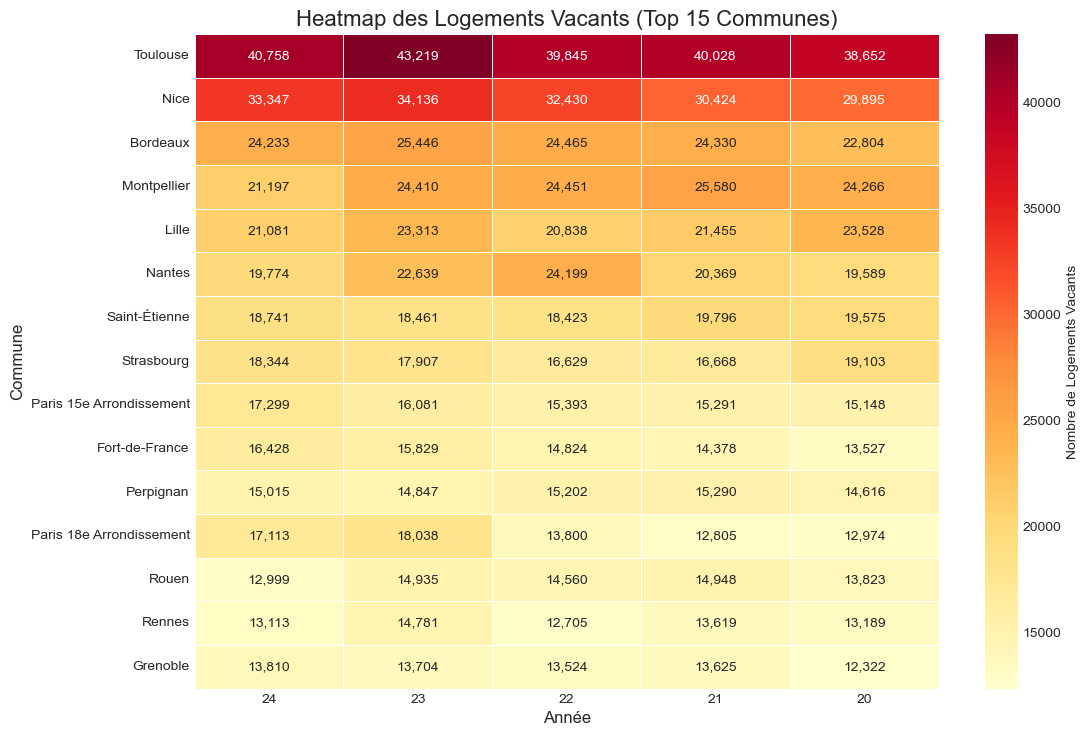

In [380]:
# 1. Identifier les colonnes à utiliser pour la heatmap (celles qui représentent les années)
# On filtre les colonnes contenant 'pp_total'
cols_vacants = [col for col in logement_vacant_trié.columns if 'pp_total' in col]

# 2. Transformer le DataFrame de format 'large' à 'long' (melt)
# Cela met toutes les valeurs d'année dans une seule colonne de 'Valeur'
df_long = logement_vacant_trié.melt(
    id_vars=['LIBGEO_25'], 
    value_vars=cols_vacants,
    var_name='Annee_Code', 
    value_name='Nombre_Vacants'
)

# 3. Nettoyer le nom de l'année pour une meilleure lisibilité (ex: '25' au lieu de '25pp_total')
df_long['Annee'] = df_long['Annee_Code'].str.replace('pp_total', '').str.replace('_', '').astype(int)

# 4. Créer la matrice (pivot) pour la heatmap
# Lignes = Zone_Geographique, Colonnes = Année, Valeurs = Nombre_Vacants
df_heatmap = df_long.pivot_table(
    index='LIBGEO_25', 
    columns='Annee', 
    values='Nombre_Vacants'
).sort_index(axis=1, ascending=False)

 # Trie les années par ordre décroissant

 # Calculer le total des logements vacants pour chaque commune
communes_par_total = df_heatmap.sum(axis=1).sort_values(ascending=False)

# Sélectionner les 15 communes avec le plus grand total
top_15_communes = communes_par_total.head(15).index

# Créer un DataFrame de heatmap réduit pour le tracé
df_heatmap_small = df_heatmap.loc[top_15_communes]

# Utilisation du DataFrame réduit (df_heatmap_small)
num_zones = len(df_heatmap_small.index)
plt.figure(figsize=(12, 1 + num_zones * 0.5))

sns.heatmap(
    df_heatmap_small,  # 👈 UTILISATION DU DATAFRAME FILTRÉ
    annot=True, 
    fmt=",.0f",             
    cmap="YlOrRd",          
    linewidths=0.5,         
    linecolor='white',
    cbar_kws={'label': 'Nombre de Logements Vacants'} 
)

plt.title(f'Heatmap des Logements Vacants (Top 15 Communes)', fontsize=16)
plt.xlabel('Année', fontsize=12)
plt.ylabel('Commune', fontsize=12)
plt.yticks(rotation=0) 
plt.show()



# Dataclean des données de transports

### Cette cellule définit l'interface ipywidgets (sélecteurs de villes et bouton), la fonction de tracé comparer_villes (qui génère un graphique à barres via seaborn) et affiche le widget. Le graphique se met à jour après la sélection de deux villes valides.

In [381]:

try:
    df_transport = pd.read_csv('nombre-de-stations-de-transports-en-commun-selon-le-type-de-reseau-commune.csv')
except FileNotFoundError:
    print("Erreur : Le fichier nombre-de-stations-de-transports-en-commun-selon-le-type-de-reseau-commune.csv n'a pas été trouvé.")
    raise

df_transport['geocode_commune'] = df_transport['geocode_commune'].astype(str)
df_metropole = df_transport[~df_transport['geocode_commune'].str.startswith('97', na=False)].copy()

df_total_stations_all = df_metropole.groupby('libelle_commune')['valeur'].sum()

villes_filtrees = df_total_stations_all[df_total_stations_all >= 5].index.tolist()

df_filtre_transport = df_metropole[df_metropole['libelle_commune'].isin(villes_filtrees)].copy()

df_total_stations_filtre = df_filtre_transport.groupby('libelle_commune')['valeur'].sum().sort_values(ascending=False)

top_villes_count = 5
top_villes = df_total_stations_filtre.head(top_villes_count).index.tolist()
toutes_villes_disponibles_transport = df_total_stations_filtre.index.tolist()

# Affichage répartition type de transports

### Cette cellule charge les données de transport, filtre les communes hors DOM-TOM et conserve uniquement celles qui possèdent 5 stations ou plus. Elle calcule ensuite le classement et identifie le TOP 5 des villes, nécessaires pour l'affichage du widget suivant.

In [382]:

def plot_transport_proportions(ville):
    """Génère un diagramme en camembert avec la légende placée à droite pour une ville donnée."""
    
    df_ville = df_filtre_transport[df_filtre_transport['libelle_commune'] == ville]
    df_proportions = df_ville.groupby('type_transport_en_commun')['valeur'].sum()
    df_proportions = df_proportions[df_proportions > 0].sort_values(ascending=False)
    
    fig, ax = plt.subplots(figsize=(10, 7)) 
    total_stations = df_proportions.sum()

    def pie_label(p, total_stations):
        absolute_count = int(p * total_stations / 100)
        if p > 3: 
            return f'{p:.1f}%\n({absolute_count:d})'
        return ''

    wedges, texts, autotexts = ax.pie(
        df_proportions, 
        autopct=lambda p: pie_label(p, total_stations),
        startangle=90, 
        textprops={'fontsize': 10},
        wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
    )
    
    ax.legend(
        wedges, 
        df_proportions.index, 
        title="Type de transport",
        loc="center left", 
        bbox_to_anchor=(1, 0, 0.5, 1) 
    )
    
    ax.set_title(
        f"Répartition des transports à {ville}", 
        fontsize=16, 
        weight='bold', 
        loc='center'
    )
    ax.text(0, -1.3, f"Total des stations : {total_stations:.0f}", 
                horizontalalignment='center', fontsize=12, style='italic', color='darkslategray')
            
    ax.axis('equal') 
    
    plt.tight_layout()
    plt.show()


title_html = widgets.HTML(
    value=f"<h2>Widget : Répartition des Transports par Commune</h2>"
)

top_list_items = ""
for i, ville in enumerate(top_villes):
    stations = df_total_stations_filtre.loc[ville]
    top_list_items += f"<li><b>{i+1}. {ville}</b> ({stations:.0f} stations)</li>"
    
label_top_5 = widgets.HTML(
    value=f"<div style='font-size:14px; padding: 10px; border-left: 5px solid #007BFF; background-color: #f8f9fa; margin: 10px 0;'><h3>TOP {top_villes_count} des Villes (5+ stations)</h3><ul>{top_list_items}</ul></div>"
)

search_box = widgets.Text(
    value='',
    placeholder='Entrez le nom de la ville à chercher...',
    description='Recherche Ville:',
    disabled=False,
    layout=widgets.Layout(width='400px')
)

status_message = widgets.Label(
    value=f"Entrez le nom d'une ville (parmi les {len(toutes_villes_disponibles_transport)} disponibles).",
    layout=widgets.Layout(margin='0 0 10px 10px')
)

output_plot_detail = widgets.Output()

def on_search_change(change):
    ville_recherchee = change.new.strip()
    
    with output_plot_detail:
        clear_output(wait=True)
        
        if not ville_recherchee:
            status_message.value = f"Entrez le nom d'une ville (parmi les {len(toutes_villes_disponibles_transport)} disponibles)."
            return

        ville_trouvee = None
        for ville in toutes_villes_disponibles_transport:
            if ville.lower() == ville_recherchee.lower():
                ville_trouvee = ville
                break
        
        if ville_trouvee:
            status_message.value = f"Affichage des transports pour : {ville_trouvee}"
            plot_transport_proportions(ville_trouvee)
        else:
            suggestions = [ville for ville in toutes_villes_disponibles_transport if ville.lower().startswith(ville_recherchee.lower())][:5]
            
            if suggestions:
                status_message.value = f"Ville non trouvée. Suggestions: {', '.join(suggestions)}..."
            else:
                status_message.value = f"Ville '{ville_recherchee}' non trouvée (ou moins de 5 stations)."

search_box.observe(on_search_change, names='value')

if top_villes:
    with output_plot_detail:
        plot_transport_proportions(top_villes[0])
        status_message.value = f"Affichage initial : {top_villes[0]}"


search_and_status = widgets.VBox([
    widgets.HBox([search_box, status_message], layout=widgets.Layout(align_items='center')),
    output_plot_detail
])

widget_final = widgets.VBox([
    title_html,
    label_top_5,
    search_and_status
])

display(widget_final)

# Dataclean des données d'éléctricité par commune

### Cette cellule charge le GeoJSON des contours de communes, le joint aux données filtrées d'insécurité (Taux_Insécurité_Total), puis utilise folium pour générer la carte interactive. La palette de couleurs est définie par les quantiles des taux supérieurs à 30.

In [383]:

try:
    df_conso = pd.read_csv("conso-2021-filtree.csv", sep=';', low_memory="False")
except FileNotFoundError:
    print("Erreur : Le fichier conso-2021-filtree.csv n'a pas été trouvé.")
    raise 

VAL_COL = 'Indice qualité'
LABEL_COL = 'Libellé Commune' 

df_elec = df_conso[df_conso['Filière'] == 'Electricité'].copy()

data_comparaison = df_elec.groupby(LABEL_COL)[VAL_COL].mean().reset_index()
data_comparaison[VAL_COL] = data_comparaison[VAL_COL].fillna(0) 

villes_disponibles_elec = sorted(data_comparaison[LABEL_COL].unique().tolist())

# Affichage de la qualité de l'électricité sous forme de diagramme comparatif

### Ce bloc charge les données de consommation, filtre uniquement les entrées pour la filière 'Electricité', puis calcule la moyenne de l''Indice qualité' pour chaque commune. La liste des communes est préparée pour l'autocomplétion dans le widget suivant.

In [384]:

ville1_select = widgets.Combobox(
    placeholder='Saisissez une ville...',
    options=villes_disponibles_elec,
    ensure_option=False,
    description='Ville 1:',
    value=villes_disponibles_elec[0] if villes_disponibles_elec else '',
    style={'description_width': 'initial'}
)

ville2_select = widgets.Combobox(
    placeholder='Saisissez une ville...',
    options=villes_disponibles_elec,
    ensure_option=False,
    description='Ville 2:',
    value=villes_disponibles_elec[1] if len(villes_disponibles_elec) > 1 else (villes_disponibles_elec[0] if villes_disponibles_elec else ''),
    style={'description_width': 'initial'}
)

bouton_comparer = widgets.Button(
    description='Comparer',
    button_style='success',
    tooltip='Cliquez pour afficher le graphique de comparaison',
    icon='check'
)

output_graph_elec = widgets.Output()


def comparer_villes(b):
    """Fonction exécutée au clic du bouton pour générer le graphique."""
    with output_graph_elec:
        clear_output(wait=True)
        
        ville1 = ville1_select.value.strip()
        ville2 = ville2_select.value.strip()
        
        # Vérification des entrées
        if ville1 not in villes_disponibles_elec or ville2 not in villes_disponibles_elec:
            villes_invalides = [v for v in [ville1, ville1] if v not in villes_disponibles_elec]
            
            print("Erreur: Les villes suivantes n'ont pas été trouvées ou sont mal orthographiées :")
            for v in set(villes_invalides):
                 print(f"- '{v}'")
            print("Veuillez vérifier l'orthographe et la casse.")
            return

        indice1 = data_comparaison[data_comparaison[LABEL_COL] == ville1][VAL_COL].iloc[0]
        indice2 = data_comparaison[data_comparaison[LABEL_COL] == ville2][VAL_COL].iloc[0]

        df_graphe = pd.DataFrame({
            'Commune': [ville1, ville2],
            'Indice de Qualité Électricité': [indice1, indice2]
        })

        plt.figure(figsize=(9, 6))
        order = [ville1, ville2]
        
        sns.barplot(
            x='Commune', 
            y='Indice de Qualité Électricité', 
            data=df_graphe,
            palette=['#4C72B0', '#55A868'],
            order=order
        )
        
        for index, row in df_graphe.set_index('Commune').loc[order].iterrows():
            plt.text(df_graphe['Commune'].tolist().index(index), row['Indice de Qualité Électricité'], 
                     f"{row['Indice de Qualité Électricité']:.3f}",
                     color='black', ha="center", va="bottom", fontsize=12, fontweight='bold')

        plt.title(f"Comparaison de la Moyenne de l'Indice de Qualité Électricité (2021)", fontsize=14)
        plt.ylabel("Moyenne de l'Indice de Qualité", fontsize=12)
        plt.xlabel("")
        plt.ylim(0, df_graphe['Indice de Qualité Électricité'].max() * 1.1)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
bouton_comparer.on_click(comparer_villes)

if villes_disponibles_elec and len(villes_disponibles_elec) > 1:
    comparer_villes(None)
    
display(HTML("<h2>Comparaison de l'Indice de Qualité Électricité</h2>"))
display(widgets.VBox([
    widgets.HBox([ville1_select, ville2_select]),
    bouton_comparer,
    output_graph_elec
]))

# Dataclean du widget complexe de la map des insécurités

### Cette cellule effectue le dataclean du fichier CSV d'insécurité. Elle convertit les taux (taux_pour_mille) au format numérique, agrège ces taux par commune (CODGEO) pour obtenir un taux total, puis filtre la liste pour ne garder que les communes dont le taux est strictement supérieur à 30 (pour mieux visualiser les zones d'intérêt sur la carte).

In [385]:

file_csv_security = "donnees_2024_insecurite.csv"

try:
    df_security = pd.read_csv(file_csv_security, sep=';', dtype={'CODGEO_2025': str})
except FileNotFoundError:
    print(f"Erreur : Le fichier {file_csv_security} n'a pas été trouvé.")
    raise

df_security['taux_pour_mille'] = df_security['taux_pour_mille'].astype(str).str.replace(',', '.')
df_security['taux_pour_mille'] = pd.to_numeric(df_security['taux_pour_mille'], errors='coerce')

df_security.dropna(subset=['taux_pour_mille'], inplace=True)
df_security['CODGEO_2025'] = df_security['CODGEO_2025'].str.zfill(5)

df_total_security = df_security.groupby('CODGEO_2025')['taux_pour_mille'].sum().reset_index()
df_total_security.rename(columns={'taux_pour_mille': 'Taux_Insécurité_Total', 'CODGEO_2025': 'CODGEO'}, inplace=True)


initial_count = len(df_total_security)
df_total_security_filtered = df_total_security[df_total_security['Taux_Insécurité_Total'] > 30].copy()
final_count = len(df_total_security_filtered)

print(f"Nombre de communes initialement: {initial_count}")
print(f"Nombre de communes conservées (Taux > 30): {final_count}")
print(f"Communes filtrées (Taux <= 30) : {initial_count - final_count}")

Nombre de communes initialement: 34911
Nombre de communes conservées (Taux > 30): 3374
Communes filtrées (Taux <= 30) : 31537


# Affichage de la carte du taux d'insécurité

### Cette cellule charge le GeoJSON des contours de communes, le joint aux données filtrées d'insécurité (Taux_Insécurité_Total), puis utilise folium pour générer la carte interactive. La palette de couleurs est définie par les quantiles des taux supérieurs à 30.

In [386]:

file_geojson_simplified = "communes-version-simplifiee.geojson"

try:
    gdf_communes = gpd.read_file(file_geojson_simplified)
except FileNotFoundError:
    print(f"Erreur : Le fichier {file_geojson_simplified} n'a pas été trouvé.")
    raise

if 'code' in gdf_communes.columns:
    gdf_communes['CODGEO'] = gdf_communes['code'].astype(str).str.zfill(5)
elif 'CODGEO' in gdf_communes.columns:
    gdf_communes['CODGEO'] = gdf_communes['CODGEO'].astype(str).str.zfill(5)

gdf_merged_security = gdf_communes.merge(
    df_total_security_filtered[['CODGEO', 'Taux_Insécurité_Total']],
    on='CODGEO',
    how='left'
)

gdf_merged_security.dropna(subset=['Taux_Insécurité_Total'], inplace=True)

print(f"Jointure réussie. Nombre de communes colorées (Taux > 30): {len(gdf_merged_security)}")

quantiles = gdf_merged_security['Taux_Insécurité_Total'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1.0]).tolist()

colormap = cm.LinearColormap(
    colors=['green', 'yellowgreen', 'yellow', 'orange', 'red', 'darkred'], 
    index=quantiles, 
    vmin=quantiles[0],
    vmax=quantiles[-1],
    caption="Taux d'Insécurité Total (Quantiles - Taux > 30)"
)

m_security = folium.Map(location=[46.603354, 1.888334], zoom_start=6)
m_security.add_child(colormap)

folium.GeoJson(
    gdf_merged_security,
    name='Taux Insécurité Total',
    style_function=lambda feature: {
        'fillColor': colormap(feature['properties']['Taux_Insécurité_Total']),
        'color': 'black',
        'weight': 0.2,
        'fillOpacity': 0.8
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['nom', 'Taux_Insécurité_Total'],
        aliases=['Commune:', "Taux Total d'Insécurité:"],
        localize=True,
        labels=True
    )
).add_to(m_security)

display(HTML("<h3>Carte des Communes (Taux d'Insécurité Total > 30)</h3>"))
display(m_security)

Jointure réussie. Nombre de communes colorées (Taux > 30): 3249


# Calcul interactif du Score d’Investissement Étudiant

Cette derniere cellule met en place un système interactif de scoring des communes françaises afin d’évaluer les meilleures opportunités d’investissement immobilier étudiant.

Il combine plusieurs sources de données (prix, loyers, insécurité, transport, vacance, etc.) et permet de pondérer dynamiquement chaque critère via des curseurs interactifs

**Fonction de calcul du score**

La fonction ``calculate_score() ``:

récupère les poids choisis par l’utilisateur,

calcule un score final pondéré pour chaque commune selon les neuf critères,

met à jour le graphique et le tableau de résultats en temps réel.

In [387]:
# --- IMPORTS NÉCESSAIRES ---
import pandas as pd
import numpy as np
from ipywidgets import interact, IntSlider, Layout
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
# Ajout pour la visualisation
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore") # Pour ignorer les avertissements de SettingWithCopyWarning, etc.

# Définition de la fonction de normalisation (Min-Max 0-100)
def normalize(series):
    """Normalisation Min-Max d'une série pandas à une échelle de 0 à 100, gère les cas extrêmes."""
    min_val = series.min()
    max_val = series.max()
    # Ajout de vérifications pour NaN/Inf ou série constante
    if pd.isna(min_val) or pd.isna(max_val) or max_val == min_val:
        # Retourne une série de 0.0 si la série est constante ou vide/NaN
        return pd.Series([0.0] * len(series), index=series.index)
    return ((series - min_val) / (max_val - min_val)) * 100

# --- 1. CHARGEMENT ET PRÉPARATION DES DONNÉES DE BASE (DVF/Loyers/Nouveaux) ---
# NOTE: Ces fichiers doivent exister dans l'environnement d'exécution.
try:
    df_2024 = pd.read_csv("communesdvf2024.csv")
    df_2023 = pd.read_csv("dvf2023.csv", sep=',', quotechar='"', index_col=0)
    df_loyers_commune = pd.read_csv("pred-app-mef-dhup.csv", sep=';', encoding='latin-1')
    df_security = pd.read_csv("donnees_2024_insecurite.csv", sep=';', dtype={'CODGEO_2025': str})
    df_transport = pd.read_csv('nombre-de-stations-de-transports-en-commun-selon-le-type-de-reseau-commune.csv')
    df_etudiant = pd.read_csv("etudiant_inscrit_detail_etablissement.csv", sep=";", encoding="utf-8-sig")
    df_logement = pd.read_csv("logement_vacant_par_ville.csv", sep=";", encoding="latin1")
    # df_etudiant est lu deux fois, on retire le doublon
    # df_etudiant = pd.read_csv("etudiant_inscrit_detail_etablissement.csv", sep=";", encoding="utf-8-sig") 

except FileNotFoundError as e:
    # Affichage d'une erreur en cas de fichier manquant
    display(HTML(f"<p style='color:red;'><strong>Erreur:</strong> Un fichier nécessaire est manquant. Veuillez vérifier les noms des fichiers: {e}</p>"))
    raise

# Nettoyage et uniformisation INSEE_COM
for df in [df_2023, df_2024]:
    if 'INSEE_COM' in df.columns:
        df['INSEE_COM'] = df['INSEE_COM'].astype(str).str.replace('"', '').str.strip().str.zfill(5)

# Nettoyage et unification des colonnes DVF
df_2023 = df_2023.rename(columns={"Annee": "annee", "Nb_mutations": "nb_mutations", "propmaison": "PropMaison", "propappart": "PropAppart"})
colonnes_dvf = ['INSEE_COM', 'annee', 'nb_mutations', 'NbApparts', 'PropAppart', 'PrixMoyen', 'Prixm2Moyen', 'SurfaceMoy']
df_dvf = pd.concat([df_2023[colonnes_dvf], df_2024[colonnes_dvf]], ignore_index=True)

# Nettoyage Loyers
df_loyers_commune = df_loyers_commune.rename(columns={'INSEE_C': 'INSEE_COM'})
df_loyers_commune['INSEE_COM'] = df_loyers_commune['INSEE_COM'].astype(str).str.zfill(5)
df_loyers_commune['loypredm2'] = pd.to_numeric(df_loyers_commune['loypredm2'].astype(str).str.replace(',', '.'), errors='coerce')
df_loyers_commune = df_loyers_commune[['INSEE_COM', 'LIBGEO', 'loypredm2']]

# Jointures DVF 2024 / Loyers
df_dvf_2024 = df_dvf[df_dvf['annee'] == 2024].copy()
df_final = pd.merge(df_dvf_2024, df_loyers_commune, on='INSEE_COM', how='inner')

# Préparation 2023 pour l'évolution
df_dvf_2023 = df_dvf[df_dvf['annee'] == 2023].copy().rename(columns={'Prixm2Moyen': 'Prixm2Moyen_2023'})
df_final = pd.merge(df_final, df_dvf_2023[['INSEE_COM', 'Prixm2Moyen_2023']], on='INSEE_COM', how='left')

# Calcul des Variables Clés (7 critères initiaux)
df_final['Prixm2Moyen_2024'] = df_final['Prixm2Moyen']
df_final['Rentabilite_Brute'] = ((df_final['loypredm2'] * 12) / (df_final['Prixm2Moyen_2024'])) * 100
df_final['Evolution_Prix_M2'] = (df_final['Prixm2Moyen_2024'] / df_final['Prixm2Moyen_2023'] - 1) * 100
df_final = df_final.rename(columns={'nb_mutations': 'Nb_Mutations'})

# Filtrage pour ne garder que les communes avec suffisamment de mutations
df_travail = df_final[df_final['Nb_Mutations'] >= 50].copy()
df_travail['INSEE_DEP'] = df_travail['INSEE_COM'].str[:2]

# --- 2. INTÉGRATION DES DONNÉES SUPPLÉMENTAIRES (Sécurité, Transport, Étudiants, Vacance) ---

# 6. Sécurité (Taux d'Insécurité)
df_security['taux_pour_mille'] = pd.to_numeric(df_security['taux_pour_mille'].astype(str).str.replace(',', '.'), errors='coerce')
df_security['CODGEO_2025'] = df_security['CODGEO_2025'].str.zfill(5)
df_total_security = df_security.groupby('CODGEO_2025')['taux_pour_mille'].sum().reset_index()
df_total_security.rename(columns={'taux_pour_mille': 'Taux_Insécurité_Total', 'CODGEO_2025': 'INSEE_COM'}, inplace=True)
df_travail = pd.merge(df_travail, df_total_security[['INSEE_COM', 'Taux_Insécurité_Total']], on='INSEE_COM', how='left')
df_travail['Taux_Insécurité_Total'] = df_travail['Taux_Insécurité_Total'].fillna(df_travail['Taux_Insécurité_Total'].median())

# 7. Transports (Nb Stations)
df_transport['geocode_commune'] = df_transport['geocode_commune'].astype(str).str.zfill(5)
df_metropole = df_transport[~df_transport['geocode_commune'].str.startswith('97', na=False)].copy()
df_total_stations = df_metropole.groupby('geocode_commune')['valeur'].sum().reset_index()
df_total_stations.rename(columns={'valeur': 'Nb_Stations_Transport', 'geocode_commune': 'INSEE_COM'}, inplace=True)
df_travail = pd.merge(df_travail, df_total_stations[['INSEE_COM', 'Nb_Stations_Transport']], on='INSEE_COM', how='left')
df_travail['Nb_Stations_Transport'] = df_travail['Nb_Stations_Transport'].fillna(0)

# 8. Population Étudiante (Nb_Etudiants)
# CORRECTION ici : Utilisation des noms de colonnes exacts du fichier etudiant_inscrit_detail_etablissement.csv
col_effectif_exact = 'nombre total d’étudiants inscrits hors doubles inscriptions université/CPGE'
col_code_commune_exact = 'code commune'

if col_effectif_exact in df_etudiant.columns and col_code_commune_exact in df_etudiant.columns:
    df_etudiant_clean = df_etudiant.rename(columns={col_code_commune_exact: 'INSEE_COM', col_effectif_exact: 'Nb_Etudiants'}).copy()
    df_etudiant_clean.loc[:, 'INSEE_COM'] = df_etudiant_clean['INSEE_COM'].astype(str).str.zfill(5)
    df_etudiant_clean.loc[:, 'Nb_Etudiants'] = pd.to_numeric(df_etudiant_clean['Nb_Etudiants'], errors='coerce').fillna(0)
    
    df_total_etudiants = df_etudiant_clean.groupby('INSEE_COM')['Nb_Etudiants'].sum().reset_index()
    df_travail = pd.merge(df_travail, df_total_etudiants, on='INSEE_COM', how='left')
    df_travail['Nb_Etudiants'] = df_travail['Nb_Etudiants'].fillna(0) 
else:
    # Ce bloc ne devrait plus s'activer avec les noms exacts
    print(f"AVERTISSEMENT: Colonnes étudiants non trouvées, 'Nb_Etudiants' est uniformément 0. Vérifiez les noms: '{col_code_commune_exact}' et '{col_effectif_exact}'.")
    df_travail['Nb_Etudiants'] = 0.0

# 9. Taux de Vacance (Inversé)
# CORRECTION ici : Utilisation des colonnes 2025 ou 2024 selon la disponibilité
df_logement_clean = df_logement.rename(columns={'CODGEO_25': 'INSEE_COM'}).copy()
df_logement_clean.loc[:, 'INSEE_COM'] = df_logement_clean['INSEE_COM'].astype(str).str.zfill(5)

# Définition des colonnes à utiliser (Priorité 25, sinon 24)
def get_vacance_cols(df):
    if all(col in df.columns for col in ["pp_vacant_25", "pp_vacant_plus_2ans_25", "pp_total_25"]):
        return {
            'vacant': "pp_vacant_25", 
            'vacant_longue': "pp_vacant_plus_2ans_25", 
            'total': "pp_total_25"
        }
    elif all(col in df.columns for col in ["pp_vacant_24", "pp_vacant_plus_2ans_24", "pp_total_24"]):
        return {
            'vacant': "pp_vacant_24", 
            'vacant_longue': "pp_vacant_plus_2ans_24", 
            'total': "pp_total_24"
        }
    return None

cols_map = get_vacance_cols(df_logement_clean)

if cols_map:
    cols_to_convert = list(cols_map.values())
    
    for col in cols_to_convert:
        # Nettoyage des chaînes ('s', 'Nan') et conversion en numérique/entier
        df_logement_clean.loc[:, col] = df_logement_clean[col].astype(str).str.replace('s', '0', regex=False).str.replace('Nan', '0', regex=False)
        # Convertir en float d'abord pour gérer les chaînes complexes, puis en int, et remplir les NaNs
        df_logement_clean.loc[:, col] = pd.to_numeric(df_logement_clean[col], errors='coerce').fillna(0).astype(int)

    # Le Taux de Vacance se calcule comme (Nombre de logements vacants / Total des logements)
    df_logement_clean.loc[:, 'Logements_Vacants'] = df_logement_clean[cols_map['vacant']]
    df_logement_clean.loc[:, 'Total_Logements'] = df_logement_clean[cols_map['total']] # pp_total_XX est bien le total
    
    # *** CORRECTION ANTI-ZERO DIVISION HERE ***
    # Créer une colonne pour le Taux de Vacance, initialisée à 0.0
    df_logement_clean.loc[:, 'Taux_Vacance'] = 0.0
    
    # Identifier les lignes où le total des logements est non nul
    mask = df_logement_clean['Total_Logements'] > 0
    
    # Appliquer la formule uniquement sur les lignes valides pour éviter la ZeroDivisionError
    df_logement_clean.loc[mask, 'Taux_Vacance'] = (
        df_logement_clean.loc[mask, 'Logements_Vacants'] / 
        df_logement_clean.loc[mask, 'Total_Logements']
    ) * 100
    
    df_logement_merge = df_logement_clean[['INSEE_COM', 'Taux_Vacance']]
else:
    # Avertissement si les colonnes n'ont pas été trouvées
    print("AVERTISSEMENT: Colonnes de vacance non trouvées ('pp_vacant_25/24', 'pp_total_25/24'). 'Taux_Vacance' est uniformément 0.")
    df_logement_merge = df_logement_clean[['INSEE_COM']].assign(Taux_Vacance=0.0)

df_travail = pd.merge(df_travail, df_logement_merge, on='INSEE_COM', how='left')

# Remplacement des NaN par la médiane (sauf si Taux_Vacance est uniforme après le merge)
if df_travail['Taux_Vacance'].std() == 0 or df_travail['Taux_Vacance'].isna().all():
     df_travail['Taux_Vacance'] = 0.0 # Garder la valeur de base si uniforme ou tout est NaN
else:
     df_travail['Taux_Vacance'] = df_travail['Taux_Vacance'].fillna(df_travail['Taux_Vacance'].median())


# --- 3. SCORING ET NORMALISATION DES 9 VARIABLES D'INVESTISSEMENT ---
df_score = df_travail.copy()

# Normalisation des 9 critères (Tous 100 = meilleur pour l'investissement)
df_score['Score_PrixM2'] = 100 - normalize(df_score['Prixm2Moyen_2024']) 
df_score['Score_LoyerM2'] = normalize(df_score['loypredm2']) 
df_score['Score_Renta'] = normalize(df_score['Rentabilite_Brute']) 
df_score['Score_Evolution'] = normalize(df_score['Evolution_Prix_M2']) 
df_score['Score_Dynamisme'] = normalize(df_score['Nb_Mutations']) 
df_score['Score_Securite'] = 100 - normalize(df_score['Taux_Insécurité_Total']) 
df_score['Score_Transport'] = normalize(df_score['Nb_Stations_Transport']) 
df_score['Score_Etudiant'] = normalize(df_score['Nb_Etudiants']) 
# Moins de vacance = tension locative élevée = Mieux.
df_score['Score_Vacance'] = 100 - normalize(df_score['Taux_Vacance']) 


# --- 4. DÉFINITION DES POIDS STRATÉGIQUES (Initialisation par défaut) ---
DEFAULT_WEIGHTS = {
    'poids_prixm2': 5,
    'poids_loyer': 4,
    'poids_renta': 3,
    'poids_dynamisme': 3,
    'poids_evolution': 2,
    'poids_securite': 1,
    'poids_transport': 1,
    'poids_etudiant': 5, 
    'poids_vacance': 3 
}


# --- 5. FONCTION DU WIDGET INTERACTIF (Affiche le tableau) ---

def calculate_score(poids_prixm2, poids_loyer, poids_renta, poids_dynamisme, poids_evolution, poids_securite, poids_transport, poids_etudiant, poids_vacance):
    
    # Efface le contenu précédent de la sortie pour mettre à jour
    clear_output(wait=True) 

    # Mise en place des poids
    poids = {
        'PrixM2': poids_prixm2,
        'Loyer': poids_loyer,
        'Renta': poids_renta,
        'Dynamisme': poids_dynamisme,
        'Evolution': poids_evolution,
        'Securite': poids_securite,
        'Transport': poids_transport,
        'Etudiant': poids_etudiant,
        'Vacance': poids_vacance
    }
    
    # Calcul du total des poids ABSOLUS
    total_poids_abs = sum(abs(v) for v in poids.values())

    if total_poids_abs == 0:
        df_scored = df_score.sort_values(by='Rentabilite_Brute', ascending=False)
        df_scored['Score_Final'] = 0.0
        texte_info = "Poids totaux à zéro. Classement par Rentabilité Brute uniquement."
    else:
        df_scored = df_score.copy()
        
        # --- DIAGNOSTIC DU PROBLÈME (Ajout de code) ---
        score_etud_var = df_scored['Score_Etudiant'].max() - df_scored['Score_Etudiant'].min()
        score_vac_var = df_scored['Score_Vacance'].max() - df_scored['Score_Vacance'].min()
        
        # Si la variance est très faible, cela signifie que tous les scores sont presque identiques, 
        # donc l'intégration de la colonne n'a pas réussi à capturer des différences entre les villes.
        if score_etud_var < 0.1 and poids['Etudiant'] != 0:
             print(f"DIAGNOSTIC: Le score étudiant est uniforme (var: {score_etud_var:.2f}). Le poids n'aura pas d'impact sur le classement.")
        if score_vac_var < 0.1 and poids['Vacance'] != 0:
             print(f"DIAGNOSTIC: Le score de vacance est uniforme (var: {score_vac_var:.2f}). Le poids n'aura pas d'impact sur le classement.")
        
        # Calcul du Score Final Pondéré (9 facteurs)
        df_scored['Score_Final'] = (
            (df_scored['Score_PrixM2'] * poids['PrixM2']) +
            (df_scored['Score_LoyerM2'] * poids['Loyer']) +
            (df_scored['Score_Renta'] * poids['Renta']) +
            (df_scored['Score_Dynamisme'] * poids['Dynamisme']) +
            (df_scored['Score_Evolution'] * poids['Evolution']) +
            (df_scored['Score_Securite'] * poids['Securite']) +
            (df_scored['Score_Transport'] * poids['Transport']) +
            (df_scored['Score_Etudiant'] * poids['Etudiant']) +
            (df_scored['Score_Vacance'] * poids['Vacance'])
        ) / total_poids_abs
        
        df_scored = df_scored.sort_values(by='Score_Final', ascending=False)
        texte_info = f"Score Calculé (Poids Total Absolu: {total_poids_abs})"

    # Préparation des Affichages
    df_classement_graph = df_scored.head(5).round(1).copy()

    # --- AFFICHAGE DU GRAPHIQUE À BARRES HORIZONTAL ---
    display(HTML(f"<h2>TOP 5 des Villes pour l'Investissement Étudiant</h2><p><i>{texte_info}</i></p>"))

    plt.figure(figsize=(12, 7))
    plt.style.use('seaborn-v0_8-whitegrid') 
    ax = sns.barplot(
        x='Score_Final', 
        y='LIBGEO', 
        data=df_classement_graph, 
        palette='viridis', 
        order=df_classement_graph['LIBGEO']
    )

    plt.title(f"Classement des Villes (Score Pondéré Personnalisé)", fontsize=18, weight='bold', pad=20)
    plt.xlabel("Score Pondéré (Max 100)", fontsize=14)
    plt.ylabel("Commune", fontsize=14)
    # Ajustement de la limite X pour afficher les étiquettes
    max_score = df_classement_graph['Score_Final'].max()
    plt.xlim(max(0, df_classement_graph['Score_Final'].min() - 5), max_score * 1.15 if max_score > 0 else 100)
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Affichage des valeurs sur les barres
    for p in ax.patches:
        width = p.get_width()
        plt.text(
            width + 1, 
            p.get_y() + p.get_height() / 2, 
            f"{width:.1f}", 
            ha='left', 
            va='center', 
            fontsize=12, 
            color='black'
        )

    sns.despine()
    plt.show()
    
    # --- AFFICHAGE DU TABLEAU DÉTAILLÉ ---
    display(HTML("<h3>Détails du TOP 5 (9 Critères) :</h3>"))
    df_output_detail = df_classement_graph[['LIBGEO', 'INSEE_DEP', 'Prixm2Moyen_2024', 'loypredm2', 'Rentabilite_Brute', 
                                           'Evolution_Prix_M2', 'Nb_Mutations', 'Nb_Etudiants', 'Taux_Vacance', 
                                           'Taux_Insécurité_Total', 'Nb_Stations_Transport', 'Score_Final']]
    df_output_detail.columns = ['Commune', 'Dép.', 'Prix m² (€)', 'Loyer m² (€)', 'Renta Brute (%)', 
                                 'Évolution Prix (%)', 'Dynamisme (mutations)', 'Nb. Étudiants', 
                                 'Taux Vacance (%)', 'Insécurité (‰)', 'Stations Transport', 'Score Final (0-100)']
                                 
    # Affichage du tableau avec dégradé
    display(df_output_detail.round({'Prix m² (€)': 0, 'Loyer m² (€)': 1, 'Renta Brute (%)': 1, 
                                     'Évolution Prix (%)': 1, 'Insécurité (‰)': 1, 'Taux Vacance (%)': 1}).style.background_gradient(subset=['Score Final (0-100)'], cmap='YlGn'))


# --- 6. CRÉATION DES CONTRÔLES INTERACTIFS ET AFFICHAGE INITIAL ---

style = {'description_width': '200px'}
layout = Layout(width='95%')

# Fonction utilitaire pour créer les sliders de -10 à 10
def create_slider(description, default_value):
    # Min=-10 et Max=10 pour permettre les poids négatifs
    return IntSlider(min=-10, max=10, step=1, value=default_value, description=description, style=style, layout=layout)

# Création des 9 Sliders
prixm2_slider = create_slider('1. Prix m² (Moins cher = Mieux)', DEFAULT_WEIGHTS['poids_prixm2'])
loyer_slider = create_slider('2. Loyer m² (Plus cher = Mieux)', DEFAULT_WEIGHTS['poids_loyer'])
renta_slider = create_slider('3. Rentabilité Brute (Plus élevée = Mieux)', DEFAULT_WEIGHTS['poids_renta'])
dynamisme_slider = create_slider('4. Dynamisme (Mutations)', DEFAULT_WEIGHTS['poids_dynamisme'])
evolution_slider = create_slider('5. Évolution Prix (Forte croissance = Mieux)', DEFAULT_WEIGHTS['poids_evolution'])
securite_slider = create_slider('6. Sécurité (Moins d\'insécurité = Mieux)', DEFAULT_WEIGHTS['poids_securite'])
transport_slider = create_slider('7. Transports (Plus de stations = Mieux)', DEFAULT_WEIGHTS['poids_transport'])
etudiant_slider = create_slider('8. Population Étudiante (Plus d\'étudiants = Mieux)', DEFAULT_WEIGHTS['poids_etudiant'])
vacance_slider = create_slider('9. Tension Locative (Moins de vacance = Mieux)', DEFAULT_WEIGHTS['poids_vacance'])


display(HTML("<h2> Score d'Opportunité Étudiant - Configuration</h2>"))
print("Ajustez les curseurs (Poids: -10 à +10) pour pondérer les 9 critères. La mise à jour est dynamique.")

# Affichage interactif unique
interact(
    calculate_score,
    poids_prixm2=prixm2_slider,
    poids_loyer=loyer_slider,
    poids_renta=renta_slider,
    poids_dynamisme=dynamisme_slider,
    poids_evolution=evolution_slider,
    poids_securite=securite_slider,
    poids_transport=transport_slider,
    poids_etudiant=etudiant_slider,
    poids_vacance=vacance_slider
);

Ajustez les curseurs (Poids: -10 à +10) pour pondérer les 9 critères. La mise à jour est dynamique.


interactive(children=(IntSlider(value=5, description='1. Prix m² (Moins cher = Mieux)', layout=Layout(width='9…

1. Chargement et préparation des données (9 critères)...
2. Normalisation et scoring des 9 critères...
3. Classement Top 5 basé sur 9 critères (Poids Total: 27).


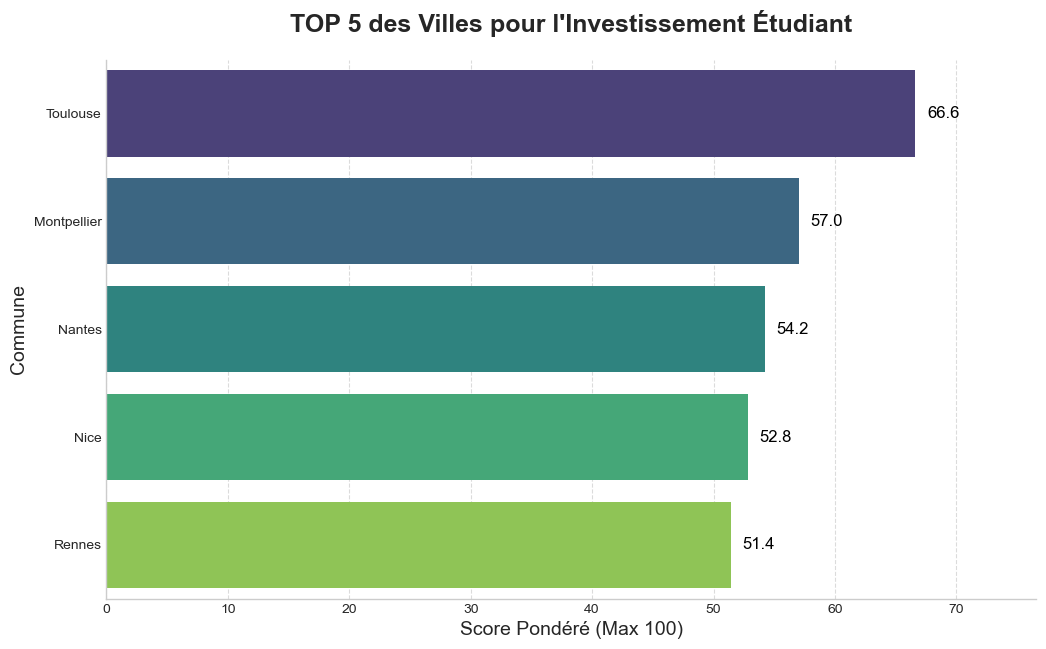

,Commune,Dép.,Prix m² (€),Loyer m² (€),Renta Brute (%),Évolution Prix (%),Dynamisme (mutations),Nb. Étudiants,Vacance (%),Insécurité (‰),Stations Transport,Score Final (0-100)
587,Toulouse,31,3497.000000,13.600000,4.700000,-3.200000,6571,978248.000000,12.800000,87.700000,782.000000,66.600000
691,Montpellier,34,3400.000000,15.000000,5.300000,-4.700000,3973,714022.000000,11.700000,89.200000,359.000000,57.000000
953,Nantes,44,3709.000000,14.200000,4.600000,-6.300000,4266,504282.000000,10.900000,76.100000,786.000000,54.200000
81,Nice,06,5116.000000,19.500000,4.600000,2.000000,6613,345497.000000,12.200000,71.500000,104.000000,52.800000
751,Rennes,35,3831.000000,14.300000,4.500000,-5.700000,2951,597596.000000,10.600000,77.900000,314.000000,51.400000


In [388]:
# --- IMPORTS NÉCESSAIRES ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore") 
plt.style.use('seaborn-v0_8-whitegrid') 

# Définition de la fonction de normalisation (Min-Max 0-100)
def normalize(series):
    """Normalisation Min-Max d'une série pandas à une échelle de 0 à 100."""
    min_val = series.min()
    max_val = series.max()
    # Gestion des séries constantes ou invalides
    if pd.isna(min_val) or pd.isna(max_val) or max_val == min_val:
        # Retourne 0.0 pour chaque élément si la série est constante ou vide/NaN
        return pd.Series([0.0] * len(series), index=series.index)
    return ((series - min_val) / (max_val - min_val)) * 100

# --- 1. CHARGEMENT ET PRÉPARATION DES DONNÉES DE BASE (DVF/Loyers + Nouveaux Fichiers) ---
print("1. Chargement et préparation des données (9 critères)...")
try:
    df_2024 = pd.read_csv("communesdvf2024.csv")
    df_2023 = pd.read_csv("dvf2023.csv", sep=',', quotechar='"', index_col=0)
    df_loyers_commune = pd.read_csv("pred-app-mef-dhup.csv", sep=';', encoding='latin-1')
    df_security = pd.read_csv("donnees_2024_insecurite.csv", sep=';', dtype={'CODGEO_2025': str})
    df_transport = pd.read_csv('nombre-de-stations-de-transports-en-commun-selon-le-type-de-reseau-commune.csv')
    df_etudiant = pd.read_csv("etudiant_inscrit_detail_etablissement.csv", sep=";", encoding="utf-8-sig")
    df_logement = pd.read_csv("logement_vacant_par_ville.csv", sep=";", encoding="latin1")
except FileNotFoundError as e:
    display(HTML(f"<p style='color:red;'><strong>Erreur:</strong> Un fichier nécessaire est manquant. Veuillez vérifier les noms des fichiers: {e}</p>"))
    raise

# Prétraitement et Jointure de la base principale (DVF/Loyers/Evo)
for df in [df_2023, df_2024]:
    if 'INSEE_COM' in df.columns:
        df['INSEE_COM'] = df['INSEE_COM'].astype(str).str.replace('"', '').str.strip().str.zfill(5)

df_2023 = df_2023.rename(columns={"Annee": "annee", "Nb_mutations": "nb_mutations", "propmaison": "PropMaison", "propappart": "PropAppart"})
colonnes_dvf = ['INSEE_COM', 'annee', 'nb_mutations', 'NbApparts', 'PropAppart', 'PrixMoyen', 'Prixm2Moyen', 'SurfaceMoy']
df_dvf = pd.concat([df_2023[colonnes_dvf], df_2024[colonnes_dvf]], ignore_index=True)

df_loyers_commune = df_loyers_commune.rename(columns={'INSEE_C': 'INSEE_COM'})
df_loyers_commune['INSEE_COM'] = df_loyers_commune['INSEE_COM'].astype(str).str.zfill(5)
df_loyers_commune['loypredm2'] = pd.to_numeric(df_loyers_commune['loypredm2'].astype(str).str.replace(',', '.'), errors='coerce')
df_loyers_commune = df_loyers_commune[['INSEE_COM', 'LIBGEO', 'loypredm2']]

df_dvf_2024 = df_dvf[df_dvf['annee'] == 2024].copy()
df_final = pd.merge(df_dvf_2024, df_loyers_commune, on='INSEE_COM', how='inner')

df_dvf_2023 = df_dvf[df_dvf['annee'] == 2023].copy().rename(columns={'Prixm2Moyen': 'Prixm2Moyen_2023'})
df_final = pd.merge(df_final, df_dvf_2023[['INSEE_COM', 'Prixm2Moyen_2023']], on='INSEE_COM', how='left')

# Calcul des Variables Clés
df_final['Prixm2Moyen_2024'] = df_final['Prixm2Moyen'] # Assurez-vous d'utiliser la colonne la plus pertinente
df_final['Rentabilite_Brute'] = ((df_final['loypredm2'] * 12) / (df_final['Prixm2Moyen_2024'])) * 100
df_final['Evolution_Prix_M2'] = (df_final['Prixm2Moyen_2024'] / df_final['Prixm2Moyen_2023'] - 1) * 100
df_final = df_final.rename(columns={'nb_mutations': 'Nb_Mutations'})

df_travail = df_final[df_final['Nb_Mutations'] >= 50].copy()
df_travail['INSEE_DEP'] = df_travail['INSEE_COM'].str[:2]


# --- 2. INTÉGRATION DES DONNÉES SUPPLÉMENTAIRES (Sécurité & Transport & Étudiants & Vacance) ---

# 6. Sécurité (Taux d'Insécurité)
df_security['taux_pour_mille'] = pd.to_numeric(df_security['taux_pour_mille'].astype(str).str.replace(',', '.'), errors='coerce')
df_security['CODGEO_2025'] = df_security['CODGEO_2025'].str.zfill(5)
df_total_security = df_security.groupby('CODGEO_2025')['taux_pour_mille'].sum().reset_index()
df_total_security.rename(columns={'taux_pour_mille': 'Taux_Insécurité_Total', 'CODGEO_2025': 'INSEE_COM'}, inplace=True)
df_travail = pd.merge(df_travail, df_total_security[['INSEE_COM', 'Taux_Insécurité_Total']], on='INSEE_COM', how='left')
df_travail['Taux_Insécurité_Total'] = df_travail['Taux_Insécurité_Total'].fillna(df_travail['Taux_Insécurité_Total'].median())

# 7. Transports (Nb Stations)
df_transport['geocode_commune'] = df_transport['geocode_commune'].astype(str).str.zfill(5)
df_metropole = df_transport[~df_transport['geocode_commune'].str.startswith('97', na=False)].copy()
df_total_stations = df_metropole.groupby('geocode_commune')['valeur'].sum().reset_index()
df_total_stations.rename(columns={'valeur': 'Nb_Stations_Transport', 'geocode_commune': 'INSEE_COM'}, inplace=True)
df_travail = pd.merge(df_travail, df_total_stations[['INSEE_COM', 'Nb_Stations_Transport']], on='INSEE_COM', how='left')
df_travail['Nb_Stations_Transport'] = df_travail['Nb_Stations_Transport'].fillna(0)

# 8. Population Étudiante (Nb_Etudiants) - Correction de l'intégration
col_effectif_exact = 'nombre total d’étudiants inscrits hors doubles inscriptions université/CPGE'
col_code_commune_exact = 'code commune'

if col_effectif_exact in df_etudiant.columns and col_code_commune_exact in df_etudiant.columns:
    df_etudiant_clean = df_etudiant.rename(columns={col_code_commune_exact: 'INSEE_COM', col_effectif_exact: 'Nb_Etudiants'}).copy()
    df_etudiant_clean.loc[:, 'INSEE_COM'] = df_etudiant_clean['INSEE_COM'].astype(str).str.zfill(5)
    df_etudiant_clean.loc[:, 'Nb_Etudiants'] = pd.to_numeric(df_etudiant_clean['Nb_Etudiants'], errors='coerce').fillna(0)
    
    df_total_etudiants = df_etudiant_clean.groupby('INSEE_COM')['Nb_Etudiants'].sum().reset_index()
    df_travail = pd.merge(df_travail, df_total_etudiants, on='INSEE_COM', how='left')
    df_travail['Nb_Etudiants'] = df_travail['Nb_Etudiants'].fillna(0) 
else:
    print("AVERTISSEMENT: Colonnes étudiants non trouvées, 'Nb_Etudiants' est uniformément 0.")
    df_travail['Nb_Etudiants'] = 0.0

# 9. Taux de Vacance (Inversé) - Correction de l'intégration pour éviter 0% uniforme
df_logement_clean = df_logement.rename(columns={'CODGEO_25': 'INSEE_COM'}).copy()
df_logement_clean.loc[:, 'INSEE_COM'] = df_logement_clean['INSEE_COM'].astype(str).str.zfill(5)

# Définition des colonnes à utiliser (Priorité 25, sinon 24)
def get_vacance_cols(df):
    if all(col in df.columns for col in ["pp_vacant_25", "pp_vacant_plus_2ans_25", "pp_total_25"]):
        return {'vacant': "pp_vacant_25", 'total': "pp_total_25"}
    elif all(col in df.columns for col in ["pp_vacant_24", "pp_vacant_plus_2ans_24", "pp_total_24"]):
        return {'vacant': "pp_vacant_24", 'total': "pp_total_24"}
    return None

cols_map = get_vacance_cols(df_logement_clean)

if cols_map:
    cols_to_convert = list(cols_map.values())
    
    for col in cols_to_convert:
        df_logement_clean.loc[:, col] = df_logement_clean[col].astype(str).str.replace('s', '0', regex=False).str.replace('Nan', '0', regex=False)
        df_logement_clean.loc[:, col] = pd.to_numeric(df_logement_clean[col], errors='coerce').fillna(0).astype(int)

    df_logement_clean.loc[:, 'Logements_Vacants'] = df_logement_clean[cols_map['vacant']]
    df_logement_clean.loc[:, 'Total_Logements'] = df_logement_clean[cols_map['total']]
    
    df_logement_clean.loc[:, 'Taux_Vacance'] = 0.0
    mask = df_logement_clean['Total_Logements'] > 0
    df_logement_clean.loc[mask, 'Taux_Vacance'] = (
        df_logement_clean.loc[mask, 'Logements_Vacants'] / 
        df_logement_clean.loc[mask, 'Total_Logements']
    ) * 100
    
    df_logement_merge = df_logement_clean[['INSEE_COM', 'Taux_Vacance']]
else:
    print("AVERTISSEMENT: Colonnes de vacance non trouvées. 'Taux_Vacance' est uniformément 0.")
    df_logement_merge = df_logement_clean[['INSEE_COM']].assign(Taux_Vacance=0.0)

df_travail = pd.merge(df_travail, df_logement_merge, on='INSEE_COM', how='left')
df_travail['Taux_Vacance'] = df_travail['Taux_Vacance'].fillna(df_travail['Taux_Vacance'].median())


# --- 3. SCORING ET NORMALISATION DES 9 VARIABLES D'INVESTISSEMENT ---
print("2. Normalisation et scoring des 9 critères...")
df_score = df_travail.copy()

# Normalisation des 9 critères (Tous 100 = meilleur pour l'investissement)
df_score['Score_PrixM2'] = 100 - normalize(df_score['Prixm2Moyen_2024']) 
df_score['Score_LoyerM2'] = normalize(df_score['loypredm2']) 
df_score['Score_Renta'] = normalize(df_score['Rentabilite_Brute']) 
df_score['Score_Evolution'] = normalize(df_score['Evolution_Prix_M2']) 
df_score['Score_Dynamisme'] = normalize(df_score['Nb_Mutations']) 
df_score['Score_Securite'] = 100 - normalize(df_score['Taux_Insécurité_Total']) 
df_score['Score_Transport'] = normalize(df_score['Nb_Stations_Transport']) 
df_score['Score_Etudiant'] = normalize(df_score['Nb_Etudiants']) 
df_score['Score_Vacance'] = 100 - normalize(df_score['Taux_Vacance']) 


# --- 4. DÉFINITION DES POIDS STRATÉGIQUES FIXES (9 CRITÈRES) ---
FIXED_WEIGHTS = {
    'PrixM2': 5,          # Moins cher = Mieux
    'Loyer': 4,           # Plus cher = Mieux
    'Renta': 3,           # Plus élevée = Mieux
    'Dynamisme': 3,       # Plus de mutations = Mieux
    'Evolution': 2,       # Forte croissance = Mieux
    'Securite': 1,        # Moins d'insécurité = Mieux
    'Transport': 1,       # Plus de stations = Mieux
    'Etudiant': 5,        # Plus d'étudiants = Mieux (Haute priorité ici)
    'Vacance': 3          # Moins de vacance = Mieux (Tension locative)
}


# --- 5. CALCUL DU SCORE FINAL PONDÉRÉ ---
poids = FIXED_WEIGHTS
total_poids_abs = sum(abs(v) for v in poids.values())

df_scored = df_score.copy()

if total_poids_abs > 0:
    df_scored['Score_Final'] = (
        (df_scored['Score_PrixM2'] * poids['PrixM2']) +
        (df_scored['Score_LoyerM2'] * poids['Loyer']) +
        (df_scored['Score_Renta'] * poids['Renta']) +
        (df_scored['Score_Dynamisme'] * poids['Dynamisme']) +
        (df_scored['Score_Evolution'] * poids['Evolution']) +
        (df_scored['Score_Securite'] * poids['Securite']) +
        (df_scored['Score_Transport'] * poids['Transport']) +
        (df_scored['Score_Etudiant'] * poids['Etudiant']) +
        (df_scored['Score_Vacance'] * poids['Vacance'])
    ) / total_poids_abs
else:
    df_scored['Score_Final'] = 0.0 # Cas impossible avec les poids fixes

df_scored = df_scored.sort_values(by='Score_Final', ascending=False)
df_classement_graph = df_scored.head(5).round(1).copy()
print(f"3. Classement Top 5 basé sur 9 critères (Poids Total: {total_poids_abs}).")


# --- 6. AFFICHAGE DES RÉSULTATS (GRAPHIQUE ET TABLEAU) ---
display(HTML("<h2>Résultat de l'Analyse d'Opportunité Étudiant (9 Critères Fixes)</h2>"))

# Affichage du Graphique
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    x='Score_Final', 
    y='LIBGEO', 
    data=df_classement_graph, 
    palette='viridis', 
    order=df_classement_graph['LIBGEO']
)

plt.title(f"TOP 5 des Villes pour l'Investissement Étudiant", fontsize=18, weight='bold', pad=20)
plt.xlabel("Score Pondéré (Max 100)", fontsize=14)
plt.ylabel("Commune", fontsize=14)
plt.xlim(0, df_classement_graph['Score_Final'].max() * 1.15)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Affichage des valeurs sur les barres
for p in ax.patches:
    width = p.get_width()
    plt.text(
        width + 1, 
        p.get_y() + p.get_height() / 2, 
        f"{width:.1f}", 
        ha='left', 
        va='center', 
        fontsize=12, 
        color='black'
    )

sns.despine()
plt.show()

# Affichage du Tableau Détaillé
display(HTML("<h3>Détails du TOP 5 (9 Critères) :</h3>"))
df_output_detail = df_classement_graph[['LIBGEO', 'INSEE_DEP', 'Prixm2Moyen_2024', 'loypredm2', 'Rentabilite_Brute', 
                                        'Evolution_Prix_M2', 'Nb_Mutations', 'Nb_Etudiants', 'Taux_Vacance', 
                                        'Taux_Insécurité_Total', 'Nb_Stations_Transport', 'Score_Final']]
df_output_detail.columns = ['Commune', 'Dép.', 'Prix m² (€)', 'Loyer m² (€)', 'Renta Brute (%)', 
                             'Évolution Prix (%)', 'Dynamisme (mutations)', 'Nb. Étudiants', 
                             'Vacance (%)', 'Insécurité (‰)', 'Stations Transport', 'Score Final (0-100)']
    
# Affichage du tableau avec dégradé
display(df_output_detail.round({'Prix m² (€)': 0, 'Loyer m² (€)': 1, 'Renta Brute (%)': 1, 
                                 'Évolution Prix (%)': 1, 'Insécurité (‰)': 1, 'Vacance (%)': 1}).style.background_gradient(subset=['Score Final (0-100)'], cmap='YlGn'))

### En conclusion, l'analyse de nos différents datasets portés sur des communes nous ont permis d'établir 9 critères (prix, loyer, rentabilité, dynamisme, sécurité, transport, vacance, et présence étudiante). Notre widget final se basant sur l'intégralité de ces critères a défini un classement final de villes à investir : Toulouse, Nice, Nantes, Dijon et Montpellier sont les villes les plus attractives pour un investissement locatif étudiant selon notre modèle. Toulouse se distingue par son dynamisme universitaire et sa bonne rentabilité, tandis que Nice et Nantes offrent un bon équilibre entre demande et valorisation du marché.
Globalement, les métropoles du Sud et de l’Ouest présentent les meilleures opportunités, combinant forte demande étudiante, tension locative élevée et cadre de vie attractif.